In [1]:
!pip install -q catboost
!pip install -q pycaret
!pip install -q optuna
!pip install -q pycaret[tuners]
!pip uninstall packaging
!pip install packaging
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.4/484.4 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 79.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.7 MB/s eta 0:

In [203]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as spst
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,classification_report,mean_absolute_percentage_error
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.impute import KNNImputer
from catboost import CatBoostRegressor,CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from statsmodels.graphics.mosaicplot import mosaic
from xgboost import XGBClassifier

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [253]:
data = pd.read_csv("/content/drive/MyDrive/dacon/흡연/train.csv")
test = pd.read_csv("/content/drive/MyDrive/dacon/흡연/test.csv")
sample_submission = pd.read_csv("/content/drive/MyDrive/dacon/흡연/sample_submission.csv")
pd.options.display.max_columns = 50

data = data.drop(['나이','키(cm)','몸무게(kg)','시력'],axis=1)
test= test.drop(['나이','키(cm)','몸무게(kg)','시력'],axis=1)

In [254]:
# data['비만'] = pd.cut(data['BMI'], bins =[0,18.5, 23, 25,30,35,100] , labels = [0,1,2,3,4,5])
data['당뇨'] = pd.cut(data['공복 혈당'], bins =[0,100, 125,10000] , labels = [0,1,2])
data['TG'] = pd.cut(data['중성 지방'], bins =[0,150, 200,10000] , labels = [0,1,2])
data = data.rename(columns={'고밀도지단백':'HDL','저밀도지단백':'LDL'})
data['HDL2'] = pd.cut(data['HDL'], bins =[0,40,60,10000] , labels = [0,1,2])
data['LDL2'] = pd.cut(data['LDL'], bins =[0,100,130,160,190,10000] , labels = [0,1,2,3,4])
data['Hemoglobin'] = pd.cut(data['헤모글로빈'], bins =[0,13,16.5,10000] , labels = [0,1,2])

data = data.astype({'당뇨':'int','TG':'int','LDL2':'int','HDL2':'int','Hemoglobin':'int'})
# data = data.astype({'당뇨':'int','TG':'int'})
# data = data.astype({'HDL2':'int','Hemoglobin':'int'})

In [255]:
# firstb = data[['충치','비만','당뇨','TG','label','ID','HDL2','LDL2','Hemoglobin','요 단백']]
# x_ = data.drop(['충치','비만','당뇨','TG','label','ID','HDL2','LDL2','Hemoglobin','요 단백'],axis=1)

# firstb = data[['충치','label','ID','요 단백']]
# x_ = data.drop(['충치','label','ID','요 단백'],axis=1)

# firstb = data[['충치','label','ID','요 단백','당뇨','TG']]
# x_ = data.drop(['충치','label','ID','요 단백','당뇨','TG'],axis=1)

# scaler = StandardScaler()
# scaler.fit(x_)

# x_train_ = scaler.transform(x_)
# x_train_ = pd.DataFrame(x_train_,index=x_.index,columns=x_.columns)
# data = pd.concat([x_train_,firstb],axis=1)
data

,ID,BMI,충치,공복 혈당,혈압,중성 지방,혈청 크레아티닌,콜레스테롤,HDL,LDL,헤모글로빈,요 단백,간 효소율,label,당뇨,TG,HDL2,LDL2,Hemoglobin
0,TRAIN_0000,24.22,1,98,40,80,1.3,211,75,120,15.9,1,1.53,1,0,0,2,1,1
1,TRAIN_0001,24.44,0,173,39,104,0.6,251,46,184,11.8,1,1.45,0,2,0,1,3,0
2,TRAIN_0002,17.30,0,96,40,61,0.8,144,43,89,15.3,1,1.04,0,0,0,1,0,1
3,TRAIN_0003,20.00,0,92,40,46,0.7,178,66,110,13.4,1,1.18,0,0,0,2,1,1
4,TRAIN_0004,27.06,0,87,42,95,0.9,232,62,151,13.8,1,1.32,0,0,0,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,TRAIN_6995,22.49,0,87,45,141,1.2,184,44,112,14.9,1,1.50,0,0,0,1,1,1
6996,TRAIN_6996,23.88,0,87,45,82,0.9,184,64,103,14.3,1,1.47,1,0,0,2,1,1
6997,TRAIN_6997,30.86,0,97,44,87,0.9,178,54,107,15.6,1,1.00,0,0,0,1,1,1
6998,TRAIN_6998,24.44,0,89,57,161,0.6,157,49,76,14.4,1,1.00,0,0,1,1,0,1


In [256]:
# data = pd.get_dummies(data,columns=['요 단백'],drop_first=True)
# data = pd.get_dummies(data,columns=['비만'],drop_first=True)
data = pd.get_dummies(data,columns=['당뇨'],drop_first=True)
data = pd.get_dummies(data,columns=['HDL2'],drop_first=True)
data = pd.get_dummies(data,columns=['LDL2'],drop_first=True)
data = pd.get_dummies(data,columns=['Hemoglobin'],drop_first=True)
data = pd.get_dummies(data,columns=['TG'],drop_first=True)

data = data.drop('ID',axis=1)
x = data.drop(['label'],axis=1)
y = data['label']

x_train, x_valid, y_train, y_valid = train_test_split(x,y,test_size=0.2, random_state=42, stratify=y)

In [257]:
data

,BMI,충치,공복 혈당,혈압,중성 지방,혈청 크레아티닌,콜레스테롤,HDL,LDL,헤모글로빈,요 단백,간 효소율,label,당뇨_1,당뇨_2,HDL2_1,HDL2_2,LDL2_1,LDL2_2,LDL2_3,LDL2_4,Hemoglobin_1,Hemoglobin_2,TG_1,TG_2
0,24.22,1,98,40,80,1.3,211,75,120,15.9,1,1.53,1,0,0,0,1,1,0,0,0,1,0,0,0
1,24.44,0,173,39,104,0.6,251,46,184,11.8,1,1.45,0,0,1,1,0,0,0,1,0,0,0,0,0
2,17.30,0,96,40,61,0.8,144,43,89,15.3,1,1.04,0,0,0,1,0,0,0,0,0,1,0,0,0
3,20.00,0,92,40,46,0.7,178,66,110,13.4,1,1.18,0,0,0,0,1,1,0,0,0,1,0,0,0
4,27.06,0,87,42,95,0.9,232,62,151,13.8,1,1.32,0,0,0,0,1,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,22.49,0,87,45,141,1.2,184,44,112,14.9,1,1.50,0,0,0,1,0,1,0,0,0,1,0,0,0
6996,23.88,0,87,45,82,0.9,184,64,103,14.3,1,1.47,1,0,0,0,1,1,0,0,0,1,0,0,0
6997,30.86,0,97,44,87,0.9,178,54,107,15.6,1,1.00,0,0,0,1,0,1,0,0,0,1,0,0,0
6998,24.44,0,89,57,161,0.6,157,49,76,14.4,1,1.00,0,0,0,1,0,0,0,0,0,1,0,1,0


In [258]:
#test
# test['비만'] = pd.cut(test['BMI'], bins =[0,18.5, 23, 25,30,35,100] , labels = [0,1,2,3,4,5])
test['당뇨'] = pd.cut(test['공복 혈당'], bins =[0,100, 125,10000] , labels = [0,1,2])
test['TG'] = pd.cut(test['중성 지방'], bins =[0,150, 200,10000] , labels = [0,1,2])
test = test.rename(columns={'고밀도지단백':'HDL','저밀도지단백':'LDL'})
test['HDL2'] = pd.cut(test['HDL'], bins =[0,40,60,10000] , labels = [0,1,2])
test['LDL2'] = pd.cut(test['LDL'], bins =[0,100,130,160,190,10000] , labels = [0,1,2,3,4])
test['Hemoglobin'] = pd.cut(test['헤모글로빈'], bins =[0,13,16.5,10000] , labels = [0,1,2])

test = test.astype({'당뇨':'int','TG':'int','LDL2':'int','HDL2':'int','Hemoglobin':'int'})
# test = test.astype({'당뇨':'int','TG':'int'})
# test = test.astype({'HDL2':'int','Hemoglobin':'int'})

In [259]:
# firstb = test[['충치','비만','당뇨','TG','ID','HDL2','LDL2','Hemoglobin','요 단백']]
# x_ = test.drop(['충치','비만','당뇨','TG','ID','HDL2','LDL2','Hemoglobin','요 단백'],axis=1)

# firstb = test[['충치','ID','요 단백']]
# x_ = test.drop(['충치','ID','요 단백'],axis=1)


# firstb = test[['충치','ID','요 단백','당뇨','TG']]
# x_ = test.drop(['충치','ID','요 단백','당뇨','TG'],axis=1)

# scaler = StandardScaler()
# scaler.fit(x_)

# x_train_ = scaler.transform(x_)
# x_train_ = pd.DataFrame(x_train_,index=x_.index,columns=x_.columns)
# test = pd.concat([x_train_,firstb],axis=1)

In [260]:
# test = pd.get_dummies(test,columns=['요 단백'],drop_first=True)
# test = pd.get_dummies(test,columns=['비만'],drop_first=True)
test = pd.get_dummies(test,columns=['당뇨'],drop_first=True)
test = pd.get_dummies(test,columns=['HDL2'],drop_first=True)
test = pd.get_dummies(test,columns=['LDL2'],drop_first=True)
test = pd.get_dummies(test,columns=['Hemoglobin'],drop_first=True)
test = pd.get_dummies(test,columns=['TG'],drop_first=True)

test = test.drop('ID',axis=1)

test

,BMI,충치,공복 혈당,혈압,중성 지방,혈청 크레아티닌,콜레스테롤,HDL,LDL,헤모글로빈,요 단백,간 효소율,당뇨_1,당뇨_2,HDL2_1,HDL2_2,LDL2_1,LDL2_2,LDL2_3,LDL2_4,Hemoglobin_1,Hemoglobin_2,TG_1,TG_2
0,20.20,1,98,47,75,0.5,229,59,155,13.7,1,1.73,0,0,1,0,0,1,0,0,1,0,0,0
1,23.78,0,99,59,98,0.6,200,65,115,12.2,1,1.00,0,0,0,1,1,0,0,0,0,0,0,0
2,29.30,0,105,34,232,0.6,170,50,73,15.1,1,1.33,1,0,1,0,0,0,0,0,1,0,0,1
3,27.78,0,78,45,218,0.9,197,55,98,15.2,1,0.89,0,0,1,0,0,0,0,0,1,0,0,1
4,22.89,0,116,67,139,1.0,230,66,136,15.0,1,0.85,1,0,0,1,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,31.14,0,94,60,146,1.1,221,55,137,14.3,1,0.72,0,0,1,0,0,1,0,0,1,0,0,0
2996,26.12,0,95,50,100,0.8,167,47,100,13.9,1,0.83,0,0,1,0,0,0,0,0,1,0,0,0
2997,24.97,1,88,32,51,0.4,186,61,114,12.8,1,1.22,0,0,0,1,1,0,0,0,0,0,0,0
2998,29.39,0,94,42,142,0.8,163,44,91,16.3,1,0.78,0,0,1,0,0,0,0,0,1,0,0,0


In [250]:
model = CatBoostClassifier(random_state=42)
model.fit(x_train,y_train)
y_pred = model.predict(x_valid)
accuracy_score(y_valid,y_pred)

Learning rate set to 0.021499
0:	learn: 0.6862997	total: 4.52ms	remaining: 4.51s
1:	learn: 0.6797164	total: 8.52ms	remaining: 4.25s
2:	learn: 0.6726794	total: 12.4ms	remaining: 4.11s
3:	learn: 0.6661228	total: 16.1ms	remaining: 4.01s
4:	learn: 0.6595511	total: 19.7ms	remaining: 3.93s
5:	learn: 0.6532297	total: 23.4ms	remaining: 3.87s
6:	learn: 0.6481454	total: 26.9ms	remaining: 3.82s
7:	learn: 0.6421731	total: 30.9ms	remaining: 3.83s
8:	learn: 0.6373064	total: 34.6ms	remaining: 3.81s
9:	learn: 0.6327198	total: 38.2ms	remaining: 3.78s
10:	learn: 0.6282052	total: 41.8ms	remaining: 3.75s
11:	learn: 0.6231097	total: 45.4ms	remaining: 3.74s
12:	learn: 0.6187452	total: 49.2ms	remaining: 3.74s
13:	learn: 0.6143566	total: 52.9ms	remaining: 3.72s
14:	learn: 0.6109813	total: 56.4ms	remaining: 3.7s
15:	learn: 0.6069713	total: 60.2ms	remaining: 3.7s
16:	learn: 0.6037617	total: 63.9ms	remaining: 3.69s
17:	learn: 0.6010475	total: 67.7ms	remaining: 3.69s
18:	learn: 0.5980276	total: 71.3ms	remaining: 

0.7164285714285714

In [251]:
model = RandomForestClassifier(random_state=42)
model.fit(x_train,y_train)
y_pred = model.predict(x_valid)
accuracy_score(y_valid,y_pred)

0.7114285714285714

In [252]:
model = XGBClassifier(random_state=42)
model.fit(x_train,y_train)
y_pred = model.predict(x_valid)
accuracy_score(y_valid,y_pred)

0.6871428571428572

,feature_name,feature_importance
0,헤모글로빈,13.477755
1,키(cm),11.930362
2,중성 지방,8.064162
3,나이,7.008665
4,간 효소율,6.390395
5,공복 혈당,6.383531
6,LDL,5.832051
7,혈청 크레아티닌,5.566372
8,HDL,5.288938
9,콜레스테롤,5.240106


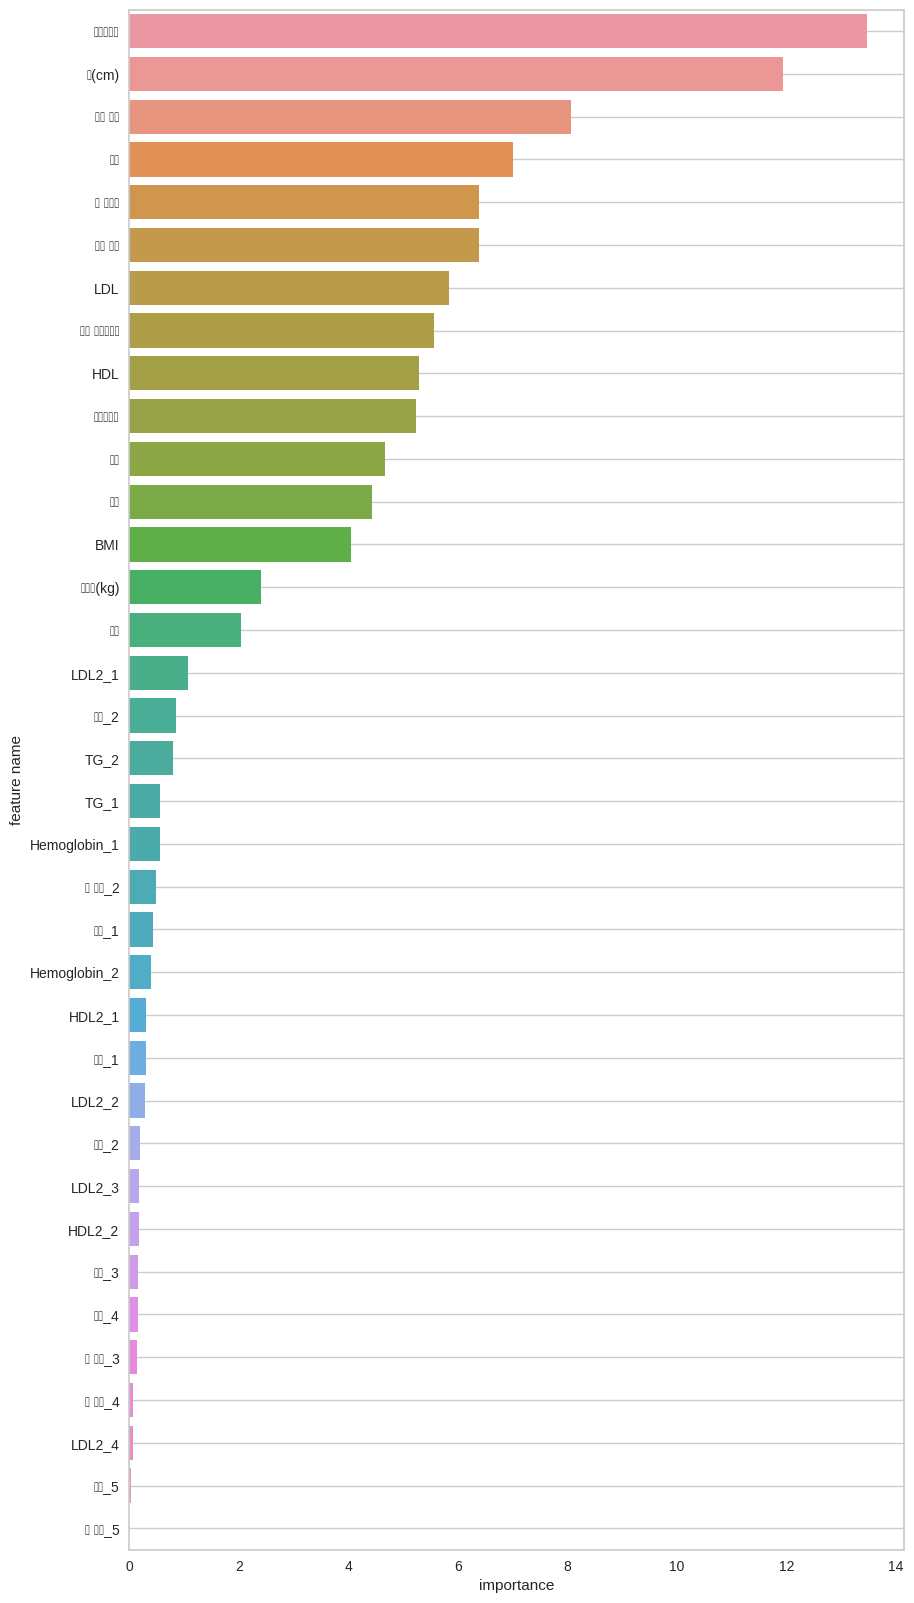

In [198]:
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df
plot_feature_importance(model.feature_importances_,x_train.columns,result_only = False)

In [201]:
from pycaret.classification import *
s = setup(data, target = 'label', session_id = 42,fold=5)

,Description,Value
0,Session id,42
1,Target,label
2,Target type,Binary
3,Original data shape,"(7000, 37)"
4,Transformed data shape,"(7000, 37)"
5,Transformed train set shape,"(4900, 37)"
6,Transformed test set shape,"(2100, 37)"
7,Numeric features,36
8,Preprocess,True
9,Imputation type,simple


In [202]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.7229,0.8035,0.6289,0.6210,0.6246,0.4050,0.4053,5.1980
gbc,Gradient Boosting Classifier,0.7196,0.7969,0.6361,0.6145,0.6246,0.4010,0.4016,1.1740
rf,Random Forest Classifier,0.7149,0.8014,0.6094,0.6127,0.6106,0.3859,0.3862,1.5760
ada,Ada Boost Classifier,0.7139,0.7864,0.6100,0.6109,0.6102,0.3842,0.3845,0.5100
lightgbm,Light Gradient Boosting Machine,0.7133,0.7912,0.6122,0.6087,0.6101,0.3834,0.3838,1.3000
xgboost,Extreme Gradient Boosting,0.7116,0.7863,0.5961,0.6096,0.6024,0.3763,0.3767,0.9060
et,Extra Trees Classifier,0.7045,0.7890,0.5611,0.6052,0.5820,0.3541,0.3549,1.4140
ridge,Ridge Classifier,0.7010,0.0000,0.5467,0.6034,0.5728,0.3439,0.3455,0.1280
lda,Linear Discriminant Analysis,0.6994,0.7827,0.5594,0.5974,0.5772,0.3446,0.3454,0.2440
lr,Logistic Regression,0.6965,0.7794,0.5389,0.5973,0.5657,0.3337,0.3353,1.7600


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [ ]:
ca = create_model('catboost',fold=5)
nb = create_model('nb',fold=5)
lightgbm = create_model('lightgbm',fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7112,0.7977,0.5806,0.6129,0.5963,0.3718,0.3721
1,0.7306,0.8073,0.6250,0.6356,0.6303,0.4184,0.4184
2,0.7337,0.8087,0.6750,0.6279,0.6506,0.4359,0.4366
3,0.7276,0.8052,0.6667,0.6202,0.6426,0.4229,0.4236
4,0.7296,0.8054,0.6333,0.6316,0.6325,0.4186,0.4186
Mean,0.7265,0.8049,0.6361,0.6256,0.6304,0.4135,0.4139
Std,0.0079,0.0038,0.0337,0.0081,0.0186,0.0218,0.0219


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6837,0.7605,0.6833,0.5566,0.6135,0.3505,0.3558
1,0.7163,0.7995,0.6972,0.5976,0.6436,0.4103,0.4137
2,0.6806,0.7525,0.7222,0.5497,0.6242,0.3553,0.3653
3,0.6867,0.7683,0.7333,0.5558,0.6323,0.3683,0.3791
4,0.6929,0.7711,0.6806,0.5684,0.6195,0.3654,0.3696
Mean,0.6920,0.7704,0.7033,0.5656,0.6266,0.3700,0.3767
Std,0.0128,0.0159,0.0210,0.0171,0.0105,0.0212,0.0200


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7082,0.7809,0.6028,0.6028,0.6028,0.3721,0.3721
1,0.7061,0.7967,0.5528,0.6104,0.5802,0.3550,0.3560
2,0.7153,0.7940,0.6722,0.6005,0.6343,0.4025,0.4042
3,0.7286,0.7951,0.6750,0.6199,0.6463,0.4267,0.4277
4,0.7082,0.7945,0.6083,0.6016,0.6050,0.3736,0.3736
Mean,0.7133,0.7922,0.6222,0.6070,0.6137,0.3860,0.3867
Std,0.0083,0.0057,0.0462,0.0073,0.0237,0.0255,0.0258


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
tune_nb = tune_model(nb, search_library = 'optuna',search_algorithm = "tpe",fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6816,0.7589,0.6778,0.5545,0.6100,0.3455,0.3505
1,0.7224,0.7998,0.7000,0.6058,0.6495,0.4217,0.4247
2,0.6806,0.7503,0.7222,0.5497,0.6242,0.3553,0.3653
3,0.6867,0.7644,0.7250,0.5565,0.6297,0.3663,0.3759
4,0.6969,0.7696,0.6667,0.5755,0.6178,0.3689,0.3717
Mean,0.6937,0.7686,0.6983,0.5684,0.6262,0.3716,0.3776
Std,0.0155,0.0169,0.0233,0.0206,0.0134,0.0264,0.0251


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

[I 2023-08-20 05:07:20,490] Searching the best hyperparameters using 4900 samples...
[I 2023-08-20 05:07:25,251] Finished hyperparameter search!


In [ ]:
tune_lightgbm = tune_model(lightgbm, search_library = 'optuna',search_algorithm = "tpe",fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7071,0.8021,0.5361,0.6166,0.5736,0.3522,0.3542
1,0.7102,0.8004,0.5250,0.6258,0.5710,0.3547,0.3578
2,0.7439,0.8099,0.6194,0.6617,0.6399,0.4415,0.4421
3,0.7224,0.7988,0.6083,0.6257,0.6169,0.3994,0.3995
4,0.7071,0.7945,0.5361,0.6166,0.5736,0.3522,0.3542
Mean,0.7182,0.8011,0.5650,0.6293,0.5950,0.3800,0.3816
Std,0.0140,0.0050,0.0403,0.0167,0.0283,0.0356,0.0348


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

[I 2023-08-20 05:07:28,364] Searching the best hyperparameters using 4900 samples...
[I 2023-08-20 05:07:57,715] Finished hyperparameter search!


In [ ]:
stacker = stack_models(estimator_list = [tune_lightgbm,ca], meta_model = tune_nb, fold=6)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6818,0.7628,0.7233,0.5508,0.6254,0.3575,0.3675
1,0.7197,0.7965,0.7067,0.6006,0.6493,0.4184,0.4223
2,0.6830,0.7677,0.7233,0.5522,0.6263,0.3595,0.3694
3,0.6867,0.7750,0.7933,0.5509,0.6503,0.3827,0.4037
4,0.7010,0.7778,0.7467,0.5714,0.6474,0.3957,0.4064
5,0.7047,0.7859,0.7367,0.5770,0.6471,0.3996,0.4084
Mean,0.6961,0.7776,0.7383,0.5671,0.6410,0.3856,0.3963
Std,0.0137,0.0112,0.0275,0.0182,0.0108,0.0218,0.0205


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
blender = blend_models(estimator_list = [tune_lightgbm,ca,tune_nb],fold=6,method="soft")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7062,0.7829,0.6800,0.5862,0.6296,0.3884,0.3914
1,0.7295,0.8088,0.6600,0.6246,0.6418,0.4248,0.4252
2,0.7050,0.7907,0.6667,0.5865,0.6240,0.3830,0.3851
3,0.7148,0.7965,0.7533,0.5870,0.6599,0.4208,0.4305
4,0.7218,0.8058,0.6900,0.6070,0.6459,0.4183,0.4207
5,0.7194,0.7968,0.6733,0.6066,0.6382,0.4100,0.4115
Mean,0.7161,0.7969,0.6872,0.5997,0.6399,0.4075,0.4107
Std,0.0086,0.0087,0.0311,0.0144,0.0115,0.0161,0.0170


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
final_best = finalize_model(stacker)
prediction = predict_model(final_best, data = test)

[LightGBM] [Warning] feature_fraction is set=0.8378883047835971, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8378883047835971
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5555583662573207, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5555583662573207
[LightGBM] [Warning] feature_fraction is set=0.8378883047835971, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8378883047835971
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5555583662573207, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5555583662573207


In [ ]:
prediction

,나이,키(cm),몸무게(kg),BMI,시력,공복 혈당,혈압,중성 지방,혈청 크레아티닌,콜레스테롤,고밀도지단백,저밀도지단백,헤모글로빈,간 효소율,충치,요 단백,prediction_label,prediction_score
0,-0.372382,0.069539,-0.835591,-1.143675,-0.276329,-0.054058,0.183970,-0.734061,-1.785419,0.898841,0.097545,1.090302,-0.580429,1.104100,1,1,0,0.9916
1,1.655841,-2.126423,-1.235651,-0.094886,-1.346333,-0.004539,1.514411,-0.412360,-1.326914,0.076557,0.503135,0.005181,-1.532333,-0.289532,0,1,0,1.0000
2,-0.372382,-0.479452,0.764647,1.522241,-0.008828,0.292573,-1.257340,1.461897,-1.326914,-0.774081,-0.510841,-1.134195,0.308015,0.340466,0,1,1,0.6735
3,-1.183670,1.716510,1.964826,1.076945,0.927426,-1.044430,-0.037770,1.266079,0.048602,-0.008506,-0.172849,-0.455995,0.371475,-0.499531,0,1,1,0.9878
4,0.438907,-1.028442,-0.835591,-0.355619,-0.677580,0.837277,2.401371,0.161107,0.507107,0.927196,0.570733,0.574870,0.244555,-0.575895,0,1,0,0.9373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,-0.372382,0.618529,1.964826,2.061284,-0.410079,-0.252132,1.625281,0.259016,0.965612,0.672004,-0.172849,0.601998,-0.199667,-0.824076,0,1,1,0.9059
2996,-1.589315,1.167519,1.164707,0.590635,-0.008828,-0.202614,0.516581,-0.384386,-0.409904,-0.859145,-0.713637,-0.401739,-0.453508,-0.614076,0,1,1,0.6977
2997,0.033263,-1.028442,-0.435532,0.253734,0.526175,-0.549244,-1.479080,-1.069749,-2.243924,-0.320407,0.232741,-0.021947,-1.151572,0.130467,1,1,0,0.9993
2998,-0.778026,1.167519,1.964826,1.548608,0.927426,-0.252132,-0.370380,0.203068,-0.409904,-0.972563,-0.916432,-0.645891,1.069539,-0.709531,0,1,1,0.9712


In [ ]:
final_best2 = finalize_model(blender)
prediction2 = predict_model(final_best2, data = test)

[LightGBM] [Warning] feature_fraction is set=0.8378883047835971, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8378883047835971
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5555583662573207, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5555583662573207
[LightGBM] [Warning] feature_fraction is set=0.8378883047835971, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8378883047835971
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5555583662573207, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5555583662573207


In [ ]:
prediction2

,나이,키(cm),몸무게(kg),BMI,시력,공복 혈당,혈압,중성 지방,혈청 크레아티닌,콜레스테롤,고밀도지단백,저밀도지단백,헤모글로빈,간 효소율,충치,요 단백,prediction_label,prediction_score
0,-0.372382,0.069539,-0.835591,-1.143675,-0.276329,-0.054058,0.183970,-0.734061,-1.785419,0.898841,0.097545,1.090302,-0.580429,1.104100,1,1,0,0.9037
1,1.655841,-2.126423,-1.235651,-0.094886,-1.346333,-0.004539,1.514411,-0.412360,-1.326914,0.076557,0.503135,0.005181,-1.532333,-0.289532,0,1,0,0.9680
2,-0.372382,-0.479452,0.764647,1.522241,-0.008828,0.292573,-1.257340,1.461897,-1.326914,-0.774081,-0.510841,-1.134195,0.308015,0.340466,0,1,1,0.5468
3,-1.183670,1.716510,1.964826,1.076945,0.927426,-1.044430,-0.037770,1.266079,0.048602,-0.008506,-0.172849,-0.455995,0.371475,-0.499531,0,1,1,0.7262
4,0.438907,-1.028442,-0.835591,-0.355619,-0.677580,0.837277,2.401371,0.161107,0.507107,0.927196,0.570733,0.574870,0.244555,-0.575895,0,1,0,0.8074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,-0.372382,0.618529,1.964826,2.061284,-0.410079,-0.252132,1.625281,0.259016,0.965612,0.672004,-0.172849,0.601998,-0.199667,-0.824076,0,1,1,0.5967
2996,-1.589315,1.167519,1.164707,0.590635,-0.008828,-0.202614,0.516581,-0.384386,-0.409904,-0.859145,-0.713637,-0.401739,-0.453508,-0.614076,0,1,0,0.5481
2997,0.033263,-1.028442,-0.435532,0.253734,0.526175,-0.549244,-1.479080,-1.069749,-2.243924,-0.320407,0.232741,-0.021947,-1.151572,0.130467,1,1,0,0.9349
2998,-0.778026,1.167519,1.964826,1.548608,0.927426,-0.252132,-0.370380,0.203068,-0.409904,-0.972563,-0.916432,-0.645891,1.069539,-0.709531,0,1,1,0.6343


In [ ]:
sample_submission['label'] = prediction['prediction_label']
sample_submission

,ID,label
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,1
3,TEST_0003,1
4,TEST_0004,0
...,...,...
2995,TEST_2995,1
2996,TEST_2996,1
2997,TEST_2997,0
2998,TEST_2998,1


In [ ]:
sample_submission.to_csv('stack2.csv',index=False)

In [ ]:
model = RandomForestClassifier(random_state=42)
model.fit(x,y)
y_pred = model.predict(test)
sample_submission['label'] = y_pred
sample_submission

,ID,label
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,1
3,TEST_0003,1
4,TEST_0004,0
...,...,...
2995,TEST_2995,0
2996,TEST_2996,0
2997,TEST_2997,0
2998,TEST_2998,1


In [ ]:
sample_submission.to_csv('rf2.csv',index=False)

In [ ]:
model = CatBoostClassifier(random_state=42)
model.fit(x,y)
y_pred = model.predict(test)
sample_submission['label'] = y_pred
sample_submission

Learning rate set to 0.023648
0:	learn: 0.6828319	total: 4.73ms	remaining: 4.72s
1:	learn: 0.6729102	total: 8.79ms	remaining: 4.39s
2:	learn: 0.6635257	total: 12.7ms	remaining: 4.23s
3:	learn: 0.6551236	total: 16.6ms	remaining: 4.12s
4:	learn: 0.6464759	total: 20.5ms	remaining: 4.08s
5:	learn: 0.6391850	total: 25ms	remaining: 4.14s
6:	learn: 0.6313297	total: 29.5ms	remaining: 4.18s
7:	learn: 0.6242829	total: 33.7ms	remaining: 4.18s
8:	learn: 0.6184661	total: 38.1ms	remaining: 4.2s
9:	learn: 0.6132019	total: 42.3ms	remaining: 4.19s
10:	learn: 0.6076997	total: 46.7ms	remaining: 4.2s
11:	learn: 0.6027773	total: 50.9ms	remaining: 4.19s
12:	learn: 0.5980996	total: 55ms	remaining: 4.17s
13:	learn: 0.5931527	total: 59.3ms	remaining: 4.18s
14:	learn: 0.5885022	total: 63.4ms	remaining: 4.16s
15:	learn: 0.5840038	total: 67.2ms	remaining: 4.13s
16:	learn: 0.5795110	total: 71.5ms	remaining: 4.13s
17:	learn: 0.5759491	total: 75.6ms	remaining: 4.13s
18:	learn: 0.5724411	total: 79.8ms	remaining: 4.12

,ID,label
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,1
3,TEST_0003,1
4,TEST_0004,0
...,...,...
2995,TEST_2995,0
2996,TEST_2996,0
2997,TEST_2997,0
2998,TEST_2998,0


In [ ]:
sample_submission.to_csv('cat2.csv',index=False)

In [ ]:
keras.backend.clear_session()

il = keras.layers.Input(shape=(23,))
hl = keras.layers.Dense(128,activation='relu')(il)
hl = keras.layers.BatchNormalization()(hl)
hl = keras.layers.Dropout(0.2)(hl)
hl = keras.layers.Dense(128,activation='relu')(hl)
hl = keras.layers.BatchNormalization()(hl)
hl = keras.layers.Dropout(0.2)(hl)
hl = keras.layers.Dense(64,activation='relu')(hl)
hl = keras.layers.BatchNormalization()(hl)
hl = keras.layers.Dropout(0.2)(hl)
hl = keras.layers.Dense(64,activation='relu')(hl)
hl = keras.layers.Dense(32,activation='relu')(hl)
ol = keras.layers.Dense(1,activation='sigmoid')(hl)

model = keras.models.Model(il,ol)
model.compile(loss="binary_crossentropy",metrics=["accuracy"],optimizer="adam")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 23)]              0         
                                                                 
 dense (Dense)               (None, 128)               3072      
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                             

In [ ]:
es = EarlyStopping(monitor="val_accuracy",
                   min_delta=0,
                   verbose=1,
                   patience = 10,
                   restore_best_weights = True)
rl = ReduceLROnPlateau(monitor="val_accuracy",
                       patience=4,
                       factor=0.25,
                       verbose=1,
                       min_lr=0.0000001)
history = model.fit(x_train,y_train,callbacks=[es,rl],epochs=100,verbose=1,validation_data=[x_valid,y_valid])

Epoch 1/100
175/175 [==============================] - 3s 6ms/step - loss: 0.5630 - accuracy: 0.6802 - val_loss: 0.5086 - val_accuracy: 0.7221 - lr: 0.0010
Epoch 2/100
175/175 [==============================] - 1s 4ms/step - loss: 0.5249 - accuracy: 0.7082 - val_loss: 0.4958 - val_accuracy: 0.7379 - lr: 0.0010
Epoch 3/100
175/175 [==============================] - 1s 5ms/step - loss: 0.5178 - accuracy: 0.7055 - val_loss: 0.4918 - val_accuracy: 0.7350 - lr: 0.0010
Epoch 4/100
175/175 [==============================] - 1s 4ms/step - loss: 0.5120 - accuracy: 0.7212 - val_loss: 0.4860 - val_accuracy: 0.7493 - lr: 0.0010
Epoch 5/100
175/175 [==============================] - 1s 5ms/step - loss: 0.5034 - accuracy: 0.7241 - val_loss: 0.4925 - val_accuracy: 0.7336 - lr: 0.0010
Epoch 6/100
175/175 [==============================] - 1s 6ms/step - loss: 0.5024 - accuracy: 0.7314 - val_loss: 0.4892 - val_accuracy: 0.7379 - lr: 0.0010
Epoch 7/100
175/175 [==============================] - 1s 7ms/st

In [ ]:
y_pred = model.predict(test)
y_pred

94/94 [==============================] - 0s 2ms/step


array([[0.08155246],
       [0.01312705],
       [0.6991566 ],
       ...,
       [0.03920278],
       [0.56719166],
       [0.04628815]], dtype=float32)

In [ ]:
y_pred_ = np.where(y_pred>=0.5,1,0)
y_pred_

array([[0],
       [0],
       [1],
       ...,
       [0],
       [1],
       [0]])

In [ ]:
sample_submission['label'] = y_pred_
sample_submission

,ID,label
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,1
3,TEST_0003,1
4,TEST_0004,0
...,...,...
2995,TEST_2995,0
2996,TEST_2996,0
2997,TEST_2997,0
2998,TEST_2998,1


In [ ]:
sample_submission['label'].value_counts()

0    1821
1    1179
Name: label, dtype: int64